In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from tqdm import tqdm
from rdkit.Chem import rdFMCS
from spyrmsd.molecule import Molecule
from spyrmsd.rmsd import rmsdwrapper
import os
from tqdm import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize


# Load data

In [2]:
original_astex = pd.read_csv('../data/astex_diverse_set.csv')
original_astex['Template'] = original_astex.PDB + '_' + original_astex.Ligand


Astex data set

In [3]:
astex = pd.read_csv('../data/astex_selected_for_docking.csv')
astex['Template'] = astex.PDB + '_' + astex.Lig

astex = astex[astex.UniProt_ID != 'P04818']

# Calculate simiarity matrix
temp_smi_dict = dict(zip(astex.Template, astex.Smiles_String))
mol_dict = {name: Chem.MolFromSmiles(smiles) for name, smiles in temp_smi_dict.items()}
fp_dict = {name: AllChem.GetMorganGenerator(radius=2, fpSize=2048).GetFingerprint(mol) for name, mol in mol_dict.items() if mol is not None}

ligand_names = list(fp_dict.keys())


[16:12:32] Explicit valence for atom # 7 Cl, 5, is greater than permitted
[16:12:32] Explicit valence for atom # 35 O, 2, is greater than permitted


In [4]:
self_fd = pd.read_csv('final_data/self_free_docking_results.csv')
self_td = pd.read_csv('final_data/self_template_docking_results.csv')

group_cols = ['UniProt_ID', 'Template', 'Docked']
uniprots = astex.UniProt_ID.unique()


# Self docking analysis

In [5]:
self_fd_worked = len(self_fd.Template.unique())
print(round(self_fd_worked/2009, 2))

0.99


In [6]:
self_td_worked = len(self_td.Template.unique())
print(round(self_td_worked/2009, 2))

0.97


In [7]:
fd_flexx_score = self_fd.dropna(subset='flexx_rmsd')
td_flexx_score = self_td.dropna(subset='flexx_rmsd')

fd_hyde_score = self_fd.dropna(subset='hyde_rmsd')
td_hyde_score = self_td.dropna(subset='hyde_rmsd')

In [8]:
fd_flexx_score_top1 = fd_flexx_score.loc[fd_flexx_score.groupby(group_cols)['flexx_score'].idxmin()]
fd_flexx_rmsd_top1 = fd_flexx_score.loc[fd_flexx_score.groupby(group_cols)['flexx_rmsd'].idxmin()]

td_flexx_score_top1 = td_flexx_score.loc[td_flexx_score.groupby(group_cols)['flexx_score'].idxmin()]
td_flexx_rmsd_top1 = td_flexx_score.loc[td_flexx_score.groupby(group_cols)['flexx_rmsd'].idxmin()]

In [9]:
fd_hyde_score_top1 = fd_hyde_score.loc[fd_hyde_score.groupby(group_cols)['hyde_score'].idxmin()]
fd_hyde_rmsd_top1 = fd_hyde_score.loc[fd_hyde_score.groupby(group_cols)['hyde_rmsd'].idxmin()]

td_hyde_score_top1 = td_hyde_score.loc[td_hyde_score.groupby(group_cols)['hyde_score'].idxmin()]
td_hyde_rmsd_top1 = td_hyde_score.loc[td_hyde_score.groupby(group_cols)['hyde_rmsd'].idxmin()]


In [10]:
fd_flexx_score_sr = round(len(fd_flexx_score_top1[fd_flexx_score_top1.flexx_rmsd <= 2])/len(fd_flexx_score_top1), 2)
fd_flexx_rmsd_sr = round(len(fd_flexx_rmsd_top1[fd_flexx_rmsd_top1.flexx_rmsd <= 2])/len(fd_flexx_rmsd_top1), 2)

td_flexx_score_sr = round(len(td_flexx_score_top1[td_flexx_score_top1.flexx_rmsd <= 2])/len(td_flexx_score_top1), 2)
td_flexx_rmsd_sr = round(len(td_flexx_rmsd_top1[td_flexx_rmsd_top1.flexx_rmsd <= 2])/len(td_flexx_rmsd_top1), 2)


In [11]:
fd_hyde_score_sr = round(len(fd_hyde_score_top1[fd_hyde_score_top1.hyde_rmsd <= 2])/len(fd_hyde_score_top1), 2)
fd_hyde_rmsd_sr = round(len(fd_hyde_rmsd_top1[fd_hyde_rmsd_top1.hyde_rmsd <= 2])/len(fd_hyde_rmsd_top1), 2)

td_hyde_score_sr = round(len(td_hyde_score_top1[td_hyde_score_top1.hyde_rmsd <= 2])/len(td_hyde_score_top1), 2)
td_hyde_rmsd_sr = round(len(td_hyde_rmsd_top1[td_hyde_rmsd_top1.hyde_rmsd <= 2])/len(td_hyde_rmsd_top1), 2)


In [12]:
self_docking_success_rate = pd.DataFrame(
     {
      'Total poses': [self_fd_worked, self_td_worked],
      '% of enriched Astex': [round(self_fd_worked/2009, 2)*100, 
                              round(self_td_worked/2009, 2)*100],
      'Poses flexx best': [len(fd_flexx_score_top1[fd_flexx_score_top1.flexx_rmsd < 2]),
                           len(td_flexx_score_top1[td_flexx_score_top1.flexx_rmsd < 2])],
      'Flexx best (%)':[fd_flexx_score_sr*100, td_flexx_score_sr*100],
      'Poses flexx top10': [len(fd_flexx_rmsd_top1[fd_flexx_rmsd_top1.flexx_rmsd < 2]),
                            len(td_flexx_rmsd_top1[td_flexx_rmsd_top1.flexx_rmsd < 2])],
      'Flexx top 10 (%)': [fd_flexx_rmsd_sr*100, td_flexx_rmsd_sr*100],
      'Poses HYDE best': [len(fd_hyde_score_top1[fd_hyde_score_top1.hyde_rmsd < 2]),
                          len(td_hyde_score_top1[td_hyde_score_top1.hyde_rmsd < 2])],
      'HYDE best (%)': [fd_hyde_score_sr*100, td_hyde_score_sr*100],
      'Poses HYDE top10': [len(fd_hyde_rmsd_top1[fd_hyde_rmsd_top1.hyde_rmsd < 2]),
                           len(td_hyde_rmsd_top1[td_hyde_rmsd_top1.hyde_rmsd < 2])],
      'HYDE top10 (%)': [fd_hyde_rmsd_sr*100, td_hyde_rmsd_sr*100]
     }, index=['Free docking', 'Template based docking']
     )
self_docking_success_rate = self_docking_success_rate.T
self_docking_success_rate = self_docking_success_rate[['Free docking', 'Template based docking']].astype(int)


In [13]:
self_docking_success_rate

,Free docking,Template based docking
Total poses,1982,1944
% of enriched Astex,99,97
Poses flexx best,903,1553
Flexx best (%),46,81
Poses flexx top10,1328,1583
Flexx top 10 (%),68,83
Poses HYDE best,1106,1442
HYDE best (%),56,75
Poses HYDE top10,1373,1561
HYDE top10 (%),71,82


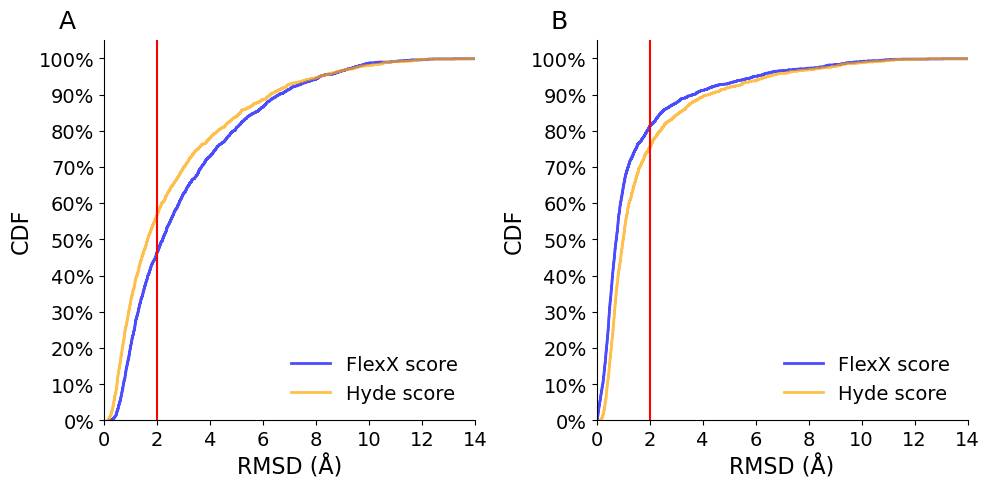

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

bins = np.arange(0, 15, 1)

# --- Plot A ---
ax = axes[0]
ax.ecdf(fd_flexx_score_top1.flexx_rmsd, alpha=0.7, label='FlexX score', linewidth=2, linestyle='-', color='blue')
ax.ecdf(fd_hyde_score_top1.hyde_rmsd, alpha=0.7, label='Hyde score',  linewidth=2, linestyle='-', color='orange')

ax.set_xlabel('RMSD (Å)', fontsize=16)
ax.set_ylabel('CDF', fontsize=16)
ax.legend(fontsize=14, frameon=False)

ax.set_xticks(np.arange(0, 15, 2))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticklabels([f"{int(ytick * 100)}%" for ytick in np.linspace(0, 1, 11)], fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlim(0, 14)
ax.set_ylim(0, 1.05)
ax.axvline(x=2, color='red', linestyle='-')
ax.text(-0.1, 1.05, 'A', fontsize=18, ha='center', va='center', transform=ax.transAxes)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# --- Plot B ---
ax = axes[1]
ax.ecdf(td_flexx_score_top1.flexx_rmsd, alpha=0.7, label='FlexX score', linewidth=2, linestyle='-', color='blue')
ax.ecdf(td_hyde_score_top1.hyde_rmsd, alpha=0.7, label='Hyde score',  linewidth=2, linestyle='-', color='orange')

ax.set_xlabel('RMSD (Å)', fontsize=16)
ax.set_ylabel('CDF', fontsize=16)  # Optional, if you want Y label on both
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticklabels([f"{int(ytick * 100)}%" for ytick in np.linspace(0, 1, 11)], fontsize=14)

ax.legend(fontsize=14, frameon=False)
ax.set_xticks(np.arange(0, 15, 2))
ax.set_xlim(0, 14)
ax.set_ylim(0, 1.05)
ax.axvline(x=2, color='red', linestyle='-')
ax.text(-0.1, 1.05, 'B', fontsize=18, ha='center', va='center', transform=ax.transAxes)
ax.tick_params(axis='x', labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')


# --- Save combined plot ---
plt.tight_layout()
# plt.show()
plt.savefig('paper_images/self_docking_ds_hs.png', dpi=300, bbox_inches='tight', transparent=True)


Check results on the original astex
HYDE paper SR:
* 76% (best)
* 92 (top20)

In [15]:
astex_hyde_sr_fd = fd_hyde_score_top1[fd_hyde_score_top1.Template.isin(original_astex.Template)]
astex_hyde_sr_td = td_hyde_score_top1[td_hyde_score_top1.Template.isin(original_astex.Template)]

astex_hyde_sr_fd_top10 = fd_hyde_rmsd_top1[fd_hyde_rmsd_top1.Template.isin(original_astex.Template)]
astex_hyde_sr_td_top10 = td_hyde_rmsd_top1[td_hyde_rmsd_top1.Template.isin(original_astex.Template)]

print(f'Astex FD best: \
{round(len(astex_hyde_sr_fd[astex_hyde_sr_fd.hyde_rmsd < 2])/len(astex_hyde_sr_fd), 2)}')

print(f'Astex TD best: \
{round(len(astex_hyde_sr_td[astex_hyde_sr_td.hyde_rmsd < 2])/len(astex_hyde_sr_td), 2)}')

print(f'Astex FD top10: \
{round(len(astex_hyde_sr_fd_top10[astex_hyde_sr_fd_top10.hyde_rmsd < 2])/len(astex_hyde_sr_fd_top10), 2)}')

print(f'Astex TD top10: \
{round(len(astex_hyde_sr_td_top10[astex_hyde_sr_td_top10.hyde_rmsd < 2])/len(astex_hyde_sr_td_top10), 2)}')

Astex FD best: 0.77
Astex TD best: 0.85
Astex FD top10: 0.85
Astex TD top10: 0.87


In [16]:
len(astex_hyde_sr_fd)

48

Finally, check SR per target and plot heatmap

In [17]:
sd_target_results = pd.DataFrame(columns=['FD Top 1 FlexX',
                                          'FD Top 1 HYDE',
                                          'TBD Top 1 FlexX',
                                          'TBD Top 1 HYDE'])

for uni in uniprots:

    target_df = fd_flexx_score_top1[fd_flexx_score_top1.UniProt_ID == uni]
    if target_df.empty:
        sd_target_results.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})', 'FD Top 1 FlexX'] = \
                            -2
    else:
        sd_target_results.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})', 'FD Top 1 FlexX'] = \
                            round(len(target_df[target_df.flexx_rmsd <= 2])/len(target_df), 2)*100

    target_df = fd_hyde_score_top1[fd_hyde_score_top1.UniProt_ID == uni]
    if target_df.empty:
        sd_target_results.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})', 'FD Top 1 HYDE'] = \
                            -2
    else:
        sd_target_results.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})', 'FD Top 1 HYDE'] = \
                            round(len(target_df[target_df.hyde_rmsd <= 2])/len(target_df), 2)*100
        
    target_df = td_flexx_score_top1[td_flexx_score_top1.UniProt_ID == uni]
    if target_df.empty:
        sd_target_results.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})', 'TBD Top 1 FlexX'] = \
                            -2
    else:
        sd_target_results.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})', 'TBD Top 1 FlexX'] = \
                            round(len(target_df[target_df.flexx_rmsd <= 2])/len(target_df), 2)*100

    target_df = td_hyde_score_top1[td_hyde_score_top1.UniProt_ID == uni]
    if target_df.empty:
        sd_target_results.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})', 'TBD Top 1 HYDE'] = \
                            -2
    else:
        sd_target_results.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})', 'TBD Top 1 HYDE'] = \
                            round(len(target_df[target_df.hyde_rmsd <= 2])/len(target_df), 2)*100

In [24]:
sd_number_of_ligands = pd.DataFrame(columns=['FD Top 1 FlexX', 'FD Top 1 HYDE', 'TBD Top 1 FlexX', 'TBD Top 1 HYDE'])

for uni in uniprots:

    target_df = fd_flexx_score_top1[fd_flexx_score_top1.UniProt_ID == uni]
    if target_df.empty: 
        sd_number_of_ligands.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})',
                                 'FD Top 1 FlexX'] = \
                                -2
    else:
        sd_number_of_ligands.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})',
                                 'FD Top 1 FlexX'] = len(target_df)    
        
    target_df = fd_hyde_score_top1[fd_hyde_score_top1.UniProt_ID == uni]    
    if target_df.empty: 
        sd_number_of_ligands.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})',
                                 'FD Top 1 HYDE'] = -2
    else:
        sd_number_of_ligands.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})',
                                 'FD Top 1 HYDE'] = len(target_df)
    
    target_df = td_flexx_score_top1[td_flexx_score_top1.UniProt_ID == uni]
    if target_df.empty: 
        sd_number_of_ligands.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})',
                                 'TBD Top 1 FlexX'] = -2
    else:
        sd_number_of_ligands.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})',
                                 'TBD Top 1 FlexX'] = len(target_df) 
        
    target_df = td_hyde_score_top1[td_hyde_score_top1.UniProt_ID == uni]
    if target_df.empty: 
        sd_number_of_ligands.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})', 
                                 'TBD Top 1 HYDE'] = -2
    else:
        sd_number_of_ligands.loc[f'{uni} ({len(astex[astex.UniProt_ID == uni])})',
                                 'TBD Top 1 HYDE'] = len(target_df)
    

In [30]:
sd_target_results.loc['P35557 (2)']

FD Top 1 FlexX     50
FD Top 1 HYDE       0
TBD Top 1 FlexX     0
TBD Top 1 HYDE      0
Name: P35557 (2), dtype: int64

In [27]:
df_colored = sd_target_results.map(lambda x: np.nan if x in [-2, -1] else x)


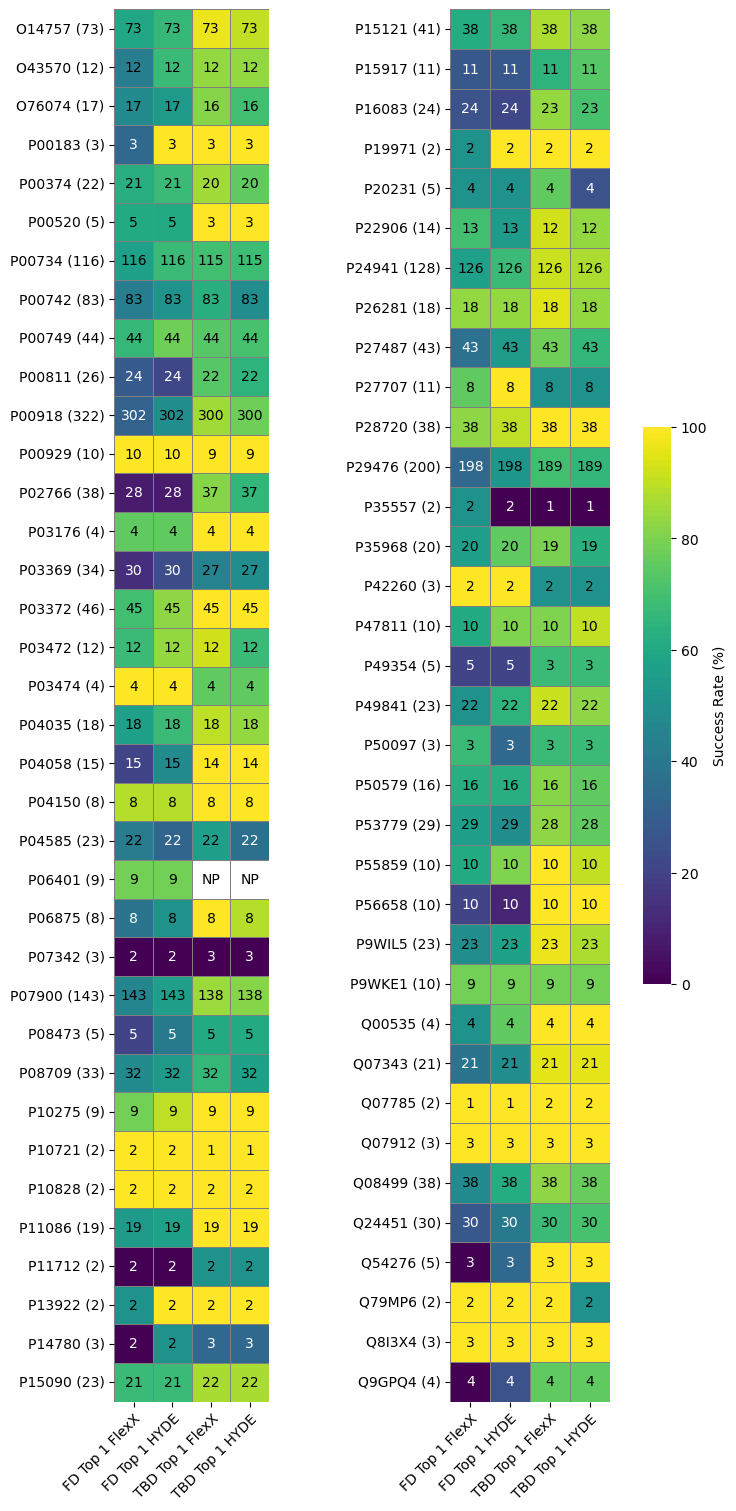

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8, 15), constrained_layout=True)
colors = list(sns.color_palette("viridis", as_cmap=True)(np.linspace(0, 1, 100)))
cmap = ListedColormap(colors)
# annot = target_sr.apply(lambda x: x if x in ['NP', 'NL'] else '')  # Only annotate NP and NL

def add_white_cells_with_annotations(ax, df_ex, target_sr):
    """
    Adds white cells with annotations to the heatmap based on specific conditions.
    """
    for (i, j), val in np.ndenumerate(df_ex.values):
        if val == -1:
            ax.text(j + 0.5, i + 0.5, 'NL', color='black', 
                    ha='center', va='center', fontsize=10)
        elif val == -2:
            ax.text(j + 0.5, i + 0.5, 'NP', color='black',
                    ha='center', va='center', fontsize=10)
        else:
            if target_sr.iloc[i, j] > 40:
                ax.text(j + 0.5, i + 0.5, int(val), 
                        color='black', ha='center', va='center', fontsize=10)
            else:
                ax.text(j + 0.5, i + 0.5, int(val), color='white', 
                        ha='center', va='center', fontsize=10)

# First heatmap
sns.heatmap(
    df_colored.iloc[:36, :],
    ax=axes[0],
    cmap=cmap,
    annot=False,
    cbar=False,
    vmin=0,
    vmax=100,
    linewidths=0.5,
    linecolor='gray',
    square=True,
#     cbar_kws={'label': 'Success Rate (%)', 'shrink': 0.6, "orientation": "vertical"}
)
add_white_cells_with_annotations(axes[0], sd_number_of_ligands.iloc[:36, :],
                                 sd_target_results.iloc[:36, :])

# Second heatmap
sns.heatmap(
    df_colored.iloc[36:, :],
    ax=axes[1],
    cmap=cmap,
    annot=False,
    cbar=False,
    vmin=0,
    vmax=100,
    linewidths=0.5,
    linecolor='gray',
    square=True,
#     cbar_kws={'label': 'Success Rate (%)', 'shrink': 0.6, "orientation": "horizontal"}
)
add_white_cells_with_annotations(axes[1], sd_number_of_ligands.iloc[36:, :],
                                 sd_target_results.iloc[36:, :])
# plt.subplots_adjust(hspace=0.3)

plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, 
         ha="right", rotation_mode="anchor") 
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, 
         ha="right", rotation_mode="anchor") 

cbar = fig.colorbar(
    axes[1].collections[0],  # Use the first heatmap's colormap
    ax=axes,
    orientation='vertical',
#     drawedges=False,
    shrink=0.4)
cbar.set_label("Success Rate (%)")
cbar.outline.set_visible(False)

# Save and show plot
plt.savefig('paper_images/self_docking_success_rates_per_target.png', dpi=300,
            bbox_inches='tight')
plt.show()